## Tweet Sentiment Extraction

#### Mini Project 3
- Email: yuehangdata@outlook.com
- Let's connect on LinkedIn: [Yue Hang Tan](https://www.linkedin.com/in/yuehangtan/)

## Data Source from Kaggle:
The data set was provided as a Kaggle competition which held in year 2020.

https://www.kaggle.com/competitions/tweet-sentiment-extraction/data

With over 20k rows of training data sets, it can help us to build some basic predictive models that could predict the sentiments of tweets, which can be useful for business applications such as find out the overall sentiment towards the product based on text reviews, identify the specific features of product that are frequently associated with negative sentiment, identify the trends, patterns or changes of sentiments towards the product over time, identify potential influencers (users with many followers) who have tweeted positively about the product, utilize the sentiment analysis results as features to build new ML model and predict the future sales trends etc.

In [1]:
# import system libraries
import os
import time
import warnings
warnings.filterwarnings("ignore")

# import NLP and regex libraries
import spacy
import nltk
import re

# import standard data science libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string

# Import text vectorizer and data processing libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from scipy.sparse import hstack, csr_matrix

# Import ML models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

In [4]:
df = pd.read_csv("train.csv")
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


### 1. EDA and data cleaning

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [6]:
# There seems to be a text row where it is NaN
df.isna().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

In [7]:
# Identify the row with NaN value in column "text"
df[df["text"].isna()]

,textID,text,selected_text,sentiment
314,fdb77c3752,NaN,NaN,neutral


In [8]:
# Drop this row
df.drop(index=314, axis=0, inplace=True)

# Inspect the df again
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


In [9]:
# Drop the "selected_text" and "textID" columns. We will do the text cleaning by ourselves
df.drop(["selected_text", "textID"], axis=1, inplace=True)
df.head(3)

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative


In [10]:
# Define a function to perform data (text) cleaning
def text_clean(df, text):
    """ 
    Note: Make sure to check if there is any float/int contained in the DataFrame before using this function.
    If the df contains any float/int, preprocess it beforehand.
    1. Input a DataFrame with text to be cleaned.
    2. Input the header of the text column
    """
    # Load English tokenizer, tagger, parser, NER and word vectors
    nlp = spacy.load("en_core_web_sm")

    # Change all the text into lower case
    df["Lower Case"] = df[text].apply(lambda x: x.lower() if type(x) == str else x)

    # Remove all the punctuations in the text
    df["Punctuations Removed"] = df["Lower Case"].apply(lambda x: re.sub("\W", " ", x) if type(x) == str else x)

    # Remove multi-spacing and new line into just single-spacing
    df["Spaces Cleaned"] = df["Punctuations Removed"].apply(lambda x: re.sub(r"(\s{2,}|\n{2,})", " ", x))

    # Return the number of characters, excluding spaces
    df["Char Counts"] = df["Punctuations Removed"].apply(lambda x: len([x for item in x if item != " "]))

    # Remove stop words
    df["No Stop Words"] = df["Spaces Cleaned"].apply(lambda x: " ".join(token.text for token in nlp(x) if token.is_stop == False))

    # Lemmatize the strings
    df["Lemmatized"] = df["No Stop Words"].apply(lambda x: " ".join(token.lemma_ for token in nlp(x.strip())))

    # Tokenize the lemmatized string and store in a list, for text vectorization purposes
    df["Tokenized"] = df["Lemmatized"].apply(lambda x: [item for item in nlp(x.strip())])

    # Return the count of words
    df["Word Counts"] = df["Spaces Cleaned"].apply(lambda x: len(x.split()))

    # Word density (average number of characters in a word)
    df["Word Density"] = df["Char Counts"] / df["Word Counts"]

    # Punctuation Counts
    df["Punctuation Counts"] = df["Lower Case"].apply(lambda x: len([item for item in x if item in string.punctuation]))

    # Remove the leading and trailing space(s), and return the tokenized text
    df["Tokenized"] = df["Lemmatized"].apply(lambda x: [item.text for item in nlp(x.strip())])
    df.head()

    return df

In [11]:
%%time
# Preview the cleaned DataFrame
df_cleaned = text_clean(df, "text")
df_cleaned.head()

,text,sentiment,Lower Case,Punctuations Removed,Spaces Cleaned,Char Counts,No Stop Words,Lemmatized,Tokenized,Word Counts,Word Density,Punctuation Counts
0,"I`d have responded, if I were going",neutral,"i`d have responded, if i were going",i d have responded if i were going,i d have responded if i were going,27,d responded going,d respond go,"[d, respond, go]",8,3.375000,2
1,Sooo SAD I will miss you here in San Diego!!!,negative,sooo sad i will miss you here in san diego!!!,sooo sad i will miss you here in san diego,sooo sad i will miss you here in san diego,33,sooo sad miss san diego,sooo sad miss san diego,"[sooo, sad, miss, san, diego]",10,3.300000,3
2,my boss is bullying me...,negative,my boss is bullying me...,my boss is bullying me,my boss is bullying me,18,boss bullying,boss bully,"[boss, bully]",5,3.600000,3
3,what interview! leave me alone,negative,what interview! leave me alone,what interview leave me alone,what interview leave me alone,25,interview leave,interview leave,"[interview, leave]",5,5.000000,1
4,"Sons of ****, why couldn`t they put them on t...",negative,"sons of ****, why couldn`t they put them on t...",sons of why couldn t they put them on t...,sons of why couldn t they put them on the rel...,55,sons couldn t releases bought,son couldn t release buy,"[son, couldn, t, release, buy]",14,3.928571,6


In [12]:
# Check the DataFrame information
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27480 entries, 0 to 27480
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   text                  27480 non-null  object 
 1   sentiment             27480 non-null  object 
 2   Lower Case            27480 non-null  object 
 3   Punctuations Removed  27480 non-null  object 
 4   Spaces Cleaned        27480 non-null  object 
 5   Char Counts           27480 non-null  int64  
 6   No Stop Words         27480 non-null  object 
 7   Lemmatized            27480 non-null  object 
 8   Tokenized             27480 non-null  object 
 9   Word Counts           27480 non-null  int64  
 10  Word Density          27478 non-null  float64
 11  Punctuation Counts    27480 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 2.7+ MB


In [13]:
# There seems to be two missing values in Word Density.
# Check what are these two rows
df_cleaned[df_cleaned["Word Density"].isna()]

,text,sentiment,Lower Case,Punctuations Removed,Spaces Cleaned,Char Counts,No Stop Words,Lemmatized,Tokenized,Word Counts,Word Density,Punctuation Counts
8120,****,negative,****,,,0,,,[],0,NaN,4
26005,?,neutral,?,,,0,,,[],0,NaN,1


In [14]:
# Apparently the text of these two rows only consist of meaningless symbols, hence there is no word counts
# Drop these two rows
df_cleaned.drop(index=[8120, 26005], axis=0, inplace=True)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27478 entries, 0 to 27480
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   text                  27478 non-null  object 
 1   sentiment             27478 non-null  object 
 2   Lower Case            27478 non-null  object 
 3   Punctuations Removed  27478 non-null  object 
 4   Spaces Cleaned        27478 non-null  object 
 5   Char Counts           27478 non-null  int64  
 6   No Stop Words         27478 non-null  object 
 7   Lemmatized            27478 non-null  object 
 8   Tokenized             27478 non-null  object 
 9   Word Counts           27478 non-null  int64  
 10  Word Density          27478 non-null  float64
 11  Punctuation Counts    27478 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 2.7+ MB


### 2. Process and split the data

In this notebook the objective is to use conventional ML models, and the workflow is as follow:
1. Vectorize features with TF-IDF.
2. Label encode target variable. Note: Must use models that do not assume ordinal relationship on label encoded data (e.g. tree-based estimators).
3. Split the data into train, validation, and test data sets.

In [15]:
# Preview the DataFrame
df_cleaned.head(3)

,text,sentiment,Lower Case,Punctuations Removed,Spaces Cleaned,Char Counts,No Stop Words,Lemmatized,Tokenized,Word Counts,Word Density,Punctuation Counts
0,"I`d have responded, if I were going",neutral,"i`d have responded, if i were going",i d have responded if i were going,i d have responded if i were going,27,d responded going,d respond go,"[d, respond, go]",8,3.375,2
1,Sooo SAD I will miss you here in San Diego!!!,negative,sooo sad i will miss you here in san diego!!!,sooo sad i will miss you here in san diego,sooo sad i will miss you here in san diego,33,sooo sad miss san diego,sooo sad miss san diego,"[sooo, sad, miss, san, diego]",10,3.300,3
2,my boss is bullying me...,negative,my boss is bullying me...,my boss is bullying me,my boss is bullying me,18,boss bullying,boss bully,"[boss, bully]",5,3.600,3


In [17]:
# Instantiate TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Vectorize the "Lemmatized" text data with TF-IDF
X_vectorized = vectorizer.fit_transform(df["Lemmatized"])

X = X_vectorized

In [19]:
# Return the target variable
y = df_cleaned["sentiment"].to_frame()
y.head()

,sentiment
0,neutral
1,negative
2,negative
3,negative
4,negative


In [20]:
# Label encode the target
y = y["sentiment"].apply(lambda x: 0 if x=="neutral" else 1 if x=="positive" else 2 if x=="negative" else x)
y.head(3)

0    0
1    2
2    2
Name: sentiment, dtype: int64

In [21]:
# Split X and y into train, validation, and test data sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, shuffle=True, random_state=42)

In [22]:
# Preview the shape of the split data sets
pd.DataFrame({
    "X_train": [X_train.shape],
    "y_train": [y_train.shape],
    "X_val": [X_val.shape],
    "y_val": [y_val.shape],
    "X_test": [X_test.shape],
    "y_test": [y_test.shape]
})

,X_train,y_train,X_val,y_val,X_test,y_test
0,"(17585, 22723)","(17585,)","(4397, 22723)","(4397,)","(5496, 22723)","(5496,)"


### 3. ML Modelling

In [23]:
# Define a function to perform model fitting and output Accuracy, Precision, Recall and F1 scores with cross_val_score.
def model_fit_score(X, y, model, random_state=1, n_splits=5):
    """ 
    1. Pass X and y (train and test) data
    2. Pass a model to be fitted with
    3. Optional: Set the random_state, random_state=
    4. Optional: Set how many splits (a.k.a. cv), n_splits=
    """
    
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    start_time = time.time()

    accuracy = round(np.array(cross_val_score(model, X, y, cv=cv, scoring="accuracy", n_jobs=-1)).mean(), 4)
    precision = round(np.array(cross_val_score(model, X, y, cv=cv, scoring="precision", n_jobs=-1)).mean(), 4)
    recall = round(np.array(cross_val_score(model, X, y, cv=cv, scoring="recall", n_jobs=-1)).mean(), 4)
    f1 = round(np.array(cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1)).mean(), 4)

    end_time = time.time()

    elapsed_time = end_time - start_time

    # model_name = re.findall("\w+", str(model.__class__))[1]

    df = pd.DataFrame({
        "Accuracy": [accuracy],
        "Precision": [precision],
        "Recall": [recall],
        "F1": [f1],
        "Elapsed Time": [elapsed_time]
    }, index=[model])

    return df

In [24]:
# Instantiate a list of models to be fitted
models_list = [LogisticRegression(n_jobs=-1, max_iter=1000), RandomForestClassifier(n_jobs=-1), XGBClassifier(n_jobs=-1)]

In [25]:
%%time
df_list = []

for item in models_list:
    print(f"Fitting {item} now...")
    df_temp = model_fit_score(X_train, y_train, item, random_state=42, n_splits=5)  # RandomForestClassifier and XGBoostClassifier can take sparse matrix directly
    df_list.append(df_temp)

results = pd.concat(df_list)
results

Fitting LogisticRegression(max_iter=1000, n_jobs=-1) now...
Fitting RandomForestClassifier(n_jobs=-1) now...
Fitting XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, ...) now...


,Accuracy,Precision,Recall,F1,Elapsed Time
"LogisticRegression(max_iter=1000, n_jobs=-1)",0.6756,NaN,NaN,NaN,21.903120
RandomForestClassifier(n_jobs=-1),0.6938,NaN,NaN,NaN,479.752745
"XGBClassifier(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, gpu_id=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=None, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimators=100, n_jobs=-1, num_parallel_tree=None,\n predictor=None, random_state=None, ...)",0.6825,NaN,NaN,NaN,62.041388


### 4. Hyperparameters tuning

RandomForestClassifier appears to be the best performer among all, so we will choose this model for hyperparameters tuning.

In [26]:
%%time
# Define the parameters to be tuned
param_grid = {
    'n_estimators': [100, 200, 500],  # Number of trees in the forest
    'max_features': ['auto', 'sqrt'],  # The number of features to consider when looking for the best split
    'max_depth': [10, 20, 30, None],  # The maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # The minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # The minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

# Re-instantiate the model
model = RandomForestClassifier(n_jobs=-1)

# Define cross-validation
cv = KFold(n_splits=3, shuffle=True, random_state=42)

# Instantiate RandomizedSearchCV
rscv_rfc = RandomizedSearchCV(estimator=model, param_distributions=param_grid, scoring="accuracy", verbose=3, random_state=42, n_iter=50, cv=cv)

# Fit with train data
rscv_rfc.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 1/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.677 total time=  11.0s
[CV 2/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.696 total time=  11.8s
[CV 3/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.698 total time=  13.5s
[CV 1/3] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=nan total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=nan total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=nan total time=   0.0s
[CV 1/3] END boot

RandomizedSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(n_jobs=-1), n_iter=50,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 500]},
                   random_state=42, scoring='accuracy', verbose=3)

In [27]:
rscv_rfc.best_params_

{'n_estimators': 500,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [28]:
rscv_rfc.best_score_

0.6915558441318034

In [29]:
rscv_rfc.best_estimator_

RandomForestClassifier(bootstrap=False, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=500, n_jobs=-1)

Discussions:
1. The base model performs better than the tuned model, so we will go with the base model.

### 5. Final results, ROC curve, confusion matrix

In [49]:
# Instantiate the base model again
model = RandomForestClassifier(n_jobs=-1)

# Fit the model with training data
model.fit(X_train, y_train)

# Make predictions with validation data
y_pred_val = model.predict(X_val)

# Return accuracy score with validation data
accuracy_val = accuracy_score(y_val, y_pred_val)
accuracy_val

0.7066181487377757

In [50]:
# Perform prediction with test data
y_pred_test = model.predict(X_test)

# Get the accuracy score with test data
accuracy_test = accuracy_score(y_test, y_pred_test)
accuracy_test

0.6974163027656477

In [51]:
# Compute y_score for ROC curve plotting
y_score = model.predict_proba(X_test)
y_score[:3]

array([[0.01      , 0.91      , 0.08      ],
       [0.08      , 0.85388889, 0.06611111],
       [0.72      , 0.13      , 0.15      ]])

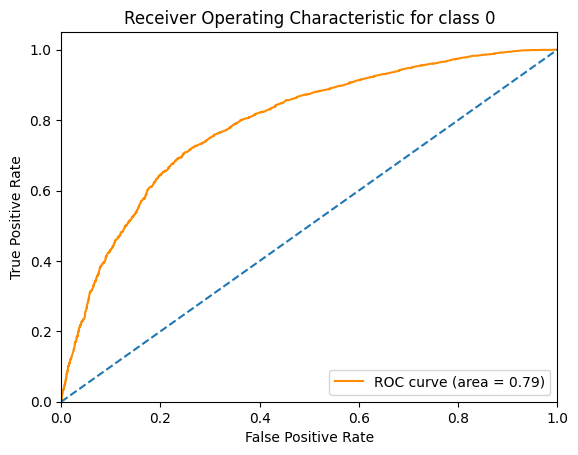

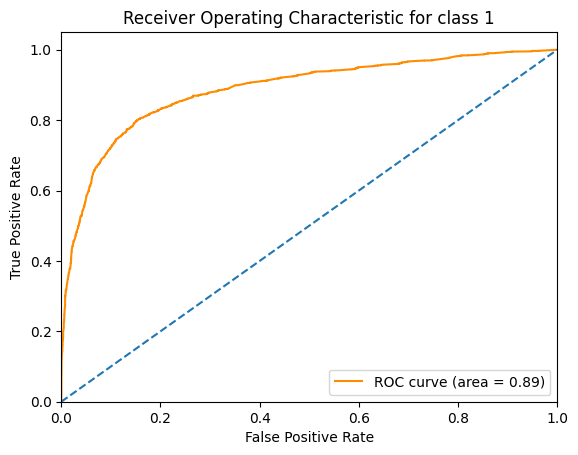

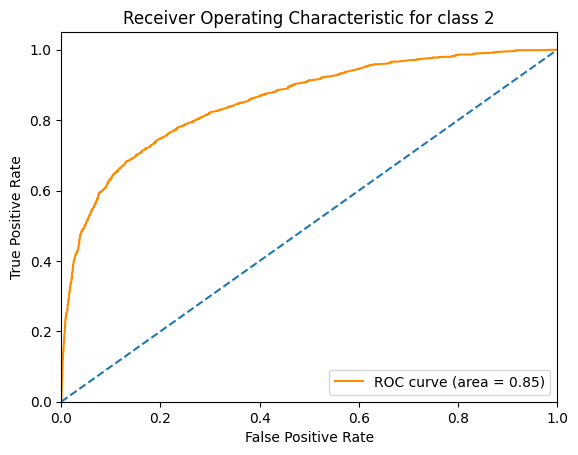

In [53]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Assuming y_test is your test set class labels
# and y_score is the output of predict_proba()

# Binarize the output
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], color="darkorange", label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for class %i' % i)
    plt.legend(loc="lower right")
    plt.show()


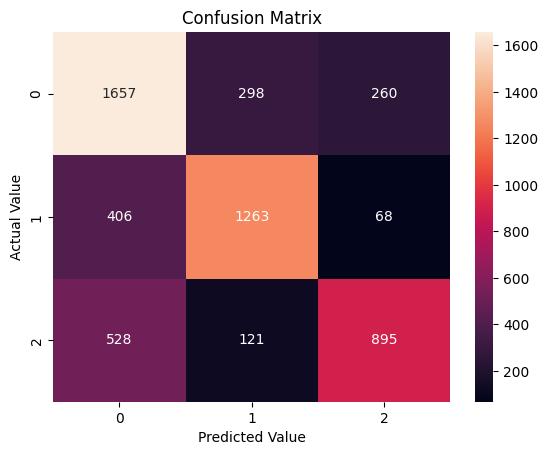

In [45]:
# Confusion matrix
cf = confusion_matrix(y_test, y_pred_test)
sns.heatmap(data=cf, annot=True, fmt="d")
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
plt.title("Confusion Matrix")
plt.show();

In [54]:
accuracy_test = accuracy_score(y_test, y_pred_test)
accuracy_test

0.6974163027656477

In [46]:
precision_test = precision_score(y_test, y_pred_test, average="macro")
precision_test

0.7074067492238032

In [47]:
recall_test = recall_score(y_test, y_pred_test, average="macro")
recall_test

0.6849533977655359

In [48]:
f1_test = f1_score(y_test, y_pred_test, average="macro")
f1_test

0.6917590841282849

In [55]:
final_results = pd.DataFrame({
    "Accuracy": [accuracy_test],
    "Precision": [precision_test],
    "Recall": [recall_test],
    "F1": [f1_test]
}, index=["Score"])

final_results

,Accuracy,Precision,Recall,F1
Score,0.697416,0.707407,0.684953,0.691759


#### Discussions:
#### 1. Check out the PowerPoint presentation slide deck for more discussions and comparisons on the models and analysis.